In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# ==== Load and Prepare Data ====
samples = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_dataframe_proc.csv')
tests = pd.read_csv(r'D:\Nam3\HK2\ATBM\DDOS\Dataset\export_tests_proc.csv')

X_train = samples.iloc[:, :-1]
y_train = samples.iloc[:, -1]
X_test = tests.iloc[:, :-1]
y_test = tests.iloc[:, -1]

# ==== Upsample ====
df = pd.concat([X_train, y_train], axis=1)
normal = df[df['Label'] == 0]
ddos = df[df['Label'] == 1]
normal_upsampled = resample(normal, replace=True, n_samples=len(ddos), random_state=27)
upsampled = pd.concat([normal_upsampled, ddos])
X_train = upsampled.iloc[:, :-1]
y_train = upsampled.iloc[:, -1]

# ==== Normalize ====
scaler = MinMaxScaler((-1, 1)).fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ==== Reshape for LSTM ====
def format_3d(X):
    return X.reshape((X.shape[0], X.shape[1], 1))

X_train_3d = format_3d(X_train)
X_test_3d = format_3d(X_test)

# ==== Define LSTM Model ====
def build_lstm_model(input_size):
    model = Sequential([
        LSTM(32, input_shape=(input_size, 1)),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

In [3]:
# ==== Evaluation Function ====
def evaluate_lstm(model, X_train, y_train, X_test, y_test, epochs, batch_size, learning_rate):
    start = time.time()
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    training_time = time.time() - start

    y_prob = model.predict(X_test).flatten()
    y_pred = (y_prob > 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    cm = confusion_matrix(y_test, y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]
    FP = cm[0, 1]

    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'Normal_Detect_Rate': TN / (TN + FP + 1e-9),
        'Atk_Detect_Rate': TP / (TP + FN + 1e-9),
        'Training_Time': training_time,
        'Confusion_Matrix': cm.tolist(),
        'ROC_FPR': fpr.tolist(),
        'ROC_TPR': tpr.tolist(),
        'ROC_AUC': roc_auc,
        'epochs': epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }

# ==== Grid Search ====
param_grid = {
    'epochs': [5, 10],
    'batch_size': [64, 128],
    'learning_rate': [0.001, 0.0005]
}

results = []
for params in ParameterGrid(param_grid):
    print(f"Training LSTM with {params}")
    model = build_lstm_model(X_train.shape[1])
    result = evaluate_lstm(
        model, X_train_3d, y_train,
        X_test_3d, y_test,
        **params
    )
    results.append(result)


Training LSTM with {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step
Training LSTM with {'batch_size': 64, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step
Training LSTM with {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 60s 6ms/step
Training LSTM with {'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step
Training LSTM with {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step
Training LSTM with {'batch_size': 128, 'epochs': 5, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 45s 4ms/step
Training LSTM with {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.001}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step
Training LSTM with {'batch_size': 128, 'epochs': 10, 'learning_rate': 0.0005}


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10681/10681 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step


In [4]:
# ==== Save All Results ====
df_results_lstm = pd.DataFrame([
    {k: v for k, v in res.items() if k not in ['ROC_FPR', 'ROC_TPR']} for res in results
])
df_results_lstm.to_csv('lstm_gridsearch_results.csv', index=False)

# ==== Save Best Result ====
best_index = df_results_lstm['Accuracy'].idxmax()
best_result = results[best_index]
df_best = pd.DataFrame([{
    k: v for k, v in best_result.items() if k not in ['ROC_FPR', 'ROC_TPR']
}])
print("\nBest Hyperparameters (LSTM - Highest Accuracy):")
print(df_best.T)
df_best.to_csv('lstm_best_result.csv', index=False)

# ==== Save ROC ====
np.save('lstm_best_roc_fpr.npy', np.array(best_result['ROC_FPR']))
np.save('lstm_best_roc_tpr.npy', np.array(best_result['ROC_TPR']))
np.save('lstm_best_roc_auc.npy', best_result['ROC_AUC'])



Best Hyperparameters (LSTM - Highest Accuracy):
                                                0
Accuracy                                 0.997613
Precision                                 0.99956
Recall                                   0.997574
F1-Score                                 0.998566
Normal_Detect_Rate                       0.997806
Atk_Detect_Rate                          0.997574
Training_Time                          339.016002
Confusion_Matrix    [[56840, 125], [691, 284134]]
ROC_AUC                                  0.999658
epochs                                          5
batch_size                                    128
learning_rate                               0.001


In [3]:
# Read the results into a DataFrame (for plotting purposes only)
grid_df = pd.read_csv(r"LSTM_gridsearch_results.csv")

In [10]:
grid_df = pd.DataFrame(grid_df)
print("==== Grid Search Results for LSTM ====")
grid_df

==== Grid Search Results for LSTM ====


,Accuracy,Precision,Recall,F1-Score,Normal_Detect_Rate,Atk_Detect_Rate,Training_Time,Confusion_Matrix,ROC_AUC,epochs,batch_size,learning_rate
0,0.996527,0.998390,0.997441,0.997915,0.991960,0.997441,469.080982,"[[56507, 458], [729, 284096]]",0.998085,5,64,0.001
1,0.994491,0.999393,0.993993,0.996686,0.996981,0.993993,512.233855,"[[56793, 172], [1711, 283114]]",0.999104,5,64,0.0005
2,0.992419,0.992527,0.998420,0.995465,0.962416,0.998420,1267.480211,"[[54824, 2141], [450, 284375]]",0.997131,10,64,0.001
3,0.989397,0.989203,0.998171,0.993667,0.945528,0.998171,2424.594610,"[[53862, 3103], [521, 284304]]",0.997758,10,64,0.0005
4,0.997613,0.999560,0.997574,0.998566,0.997806,0.997574,339.016002,"[[56840, 125], [691, 284134]]",0.999658,5,128,0.001
5,0.997279,0.998605,0.998129,0.998367,0.993031,0.998129,350.298243,"[[56568, 397], [533, 284292]]",0.999436,5,128,0.0005
6,0.990895,0.989927,0.999242,0.994563,0.949162,0.999242,1201.527199,"[[54069, 2896], [216, 284609]]",0.997885,10,128,0.001
7,0.993192,0.993598,0.998262,0.995925,0.967840,0.998262,1577.500235,"[[55133, 1832], [495, 284330]]",0.999657,10,128,0.0005


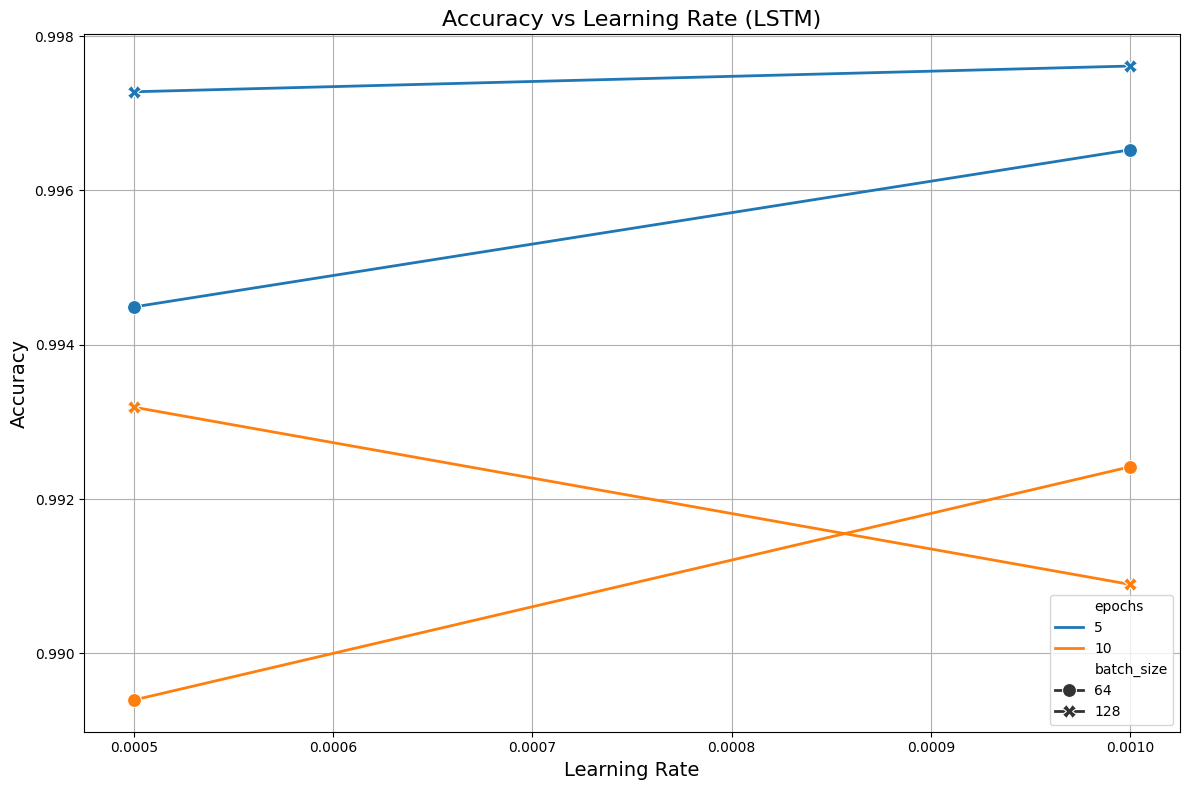

In [4]:
plt.figure(figsize=(12, 8))

# Plot Accuracy vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Accuracy',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',  # Different palette for Accuracy
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Adding title and labels for Accuracy plot
plt.title("Accuracy vs Learning Rate (LSTM)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)

# Adjust grid and layout for Accuracy plot
plt.grid(True)
plt.tight_layout()

# Show the Accuracy plot
plt.show()

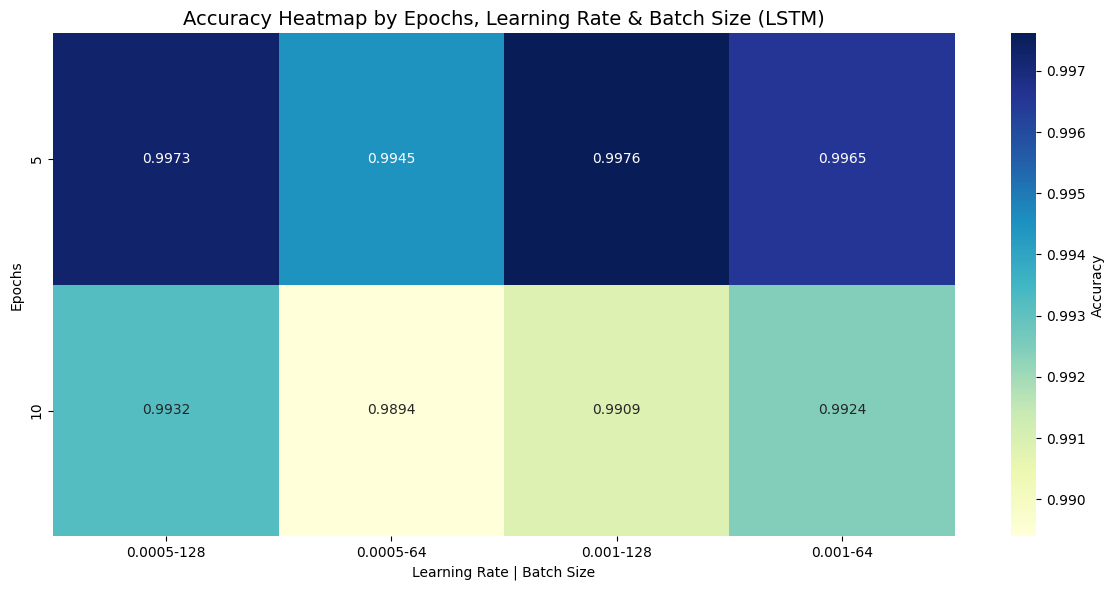

In [5]:
grid_df['learning_rate'] = grid_df['learning_rate'].astype(str)
grid_df['batch_size'] = grid_df['batch_size'].astype(str)

# Create a pivot table with MultiIndex columns: (learning_rate, batch_size)
heatmap_data = grid_df.pivot_table(
    index='epochs',
    columns=['learning_rate', 'batch_size'],
    values='Accuracy',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".4f",
    cmap="YlGnBu",
    cbar_kws={'label': 'Accuracy'}
)

plt.title("Accuracy Heatmap by Epochs, Learning Rate & Batch Size (LSTM)", fontsize=14)
plt.xlabel("Learning Rate | Batch Size")
plt.ylabel("Epochs")
plt.tight_layout()
plt.show()

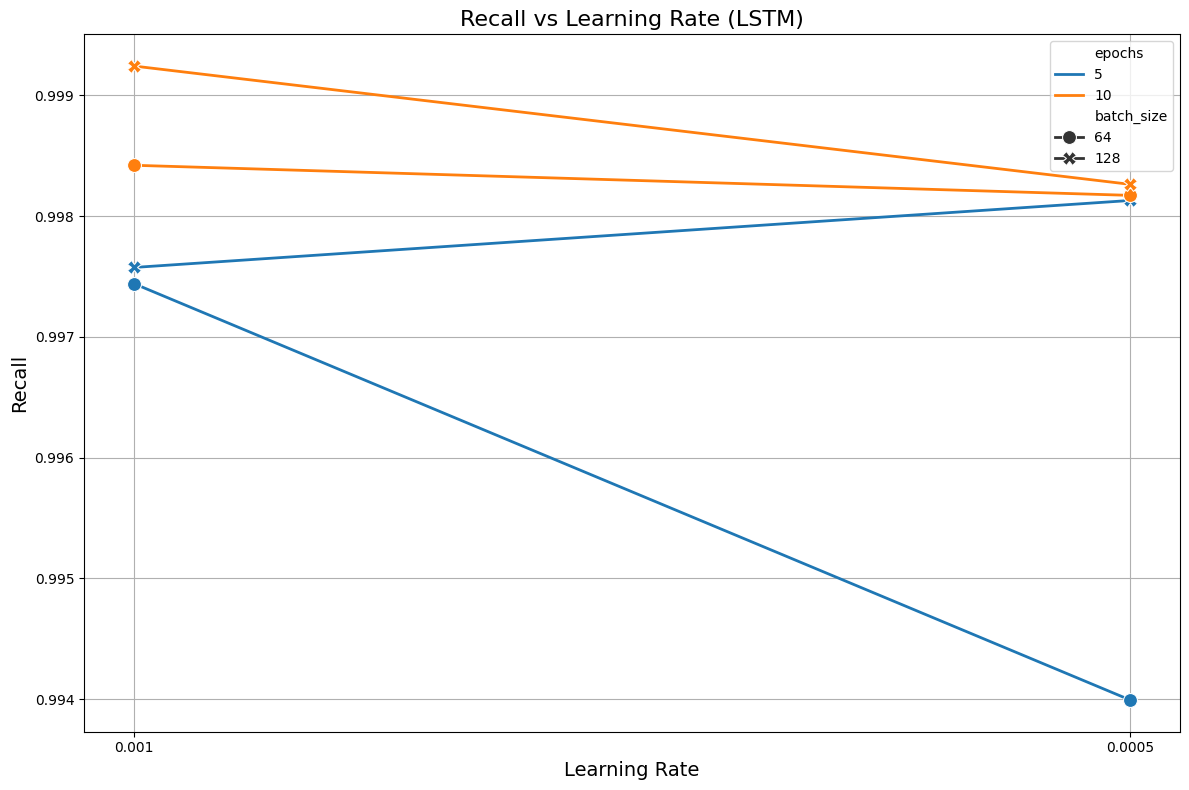

In [6]:
plt.figure(figsize=(12, 8))

# Plot Recall vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Recall',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Recall vs Learning Rate (LSTM)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Recall", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

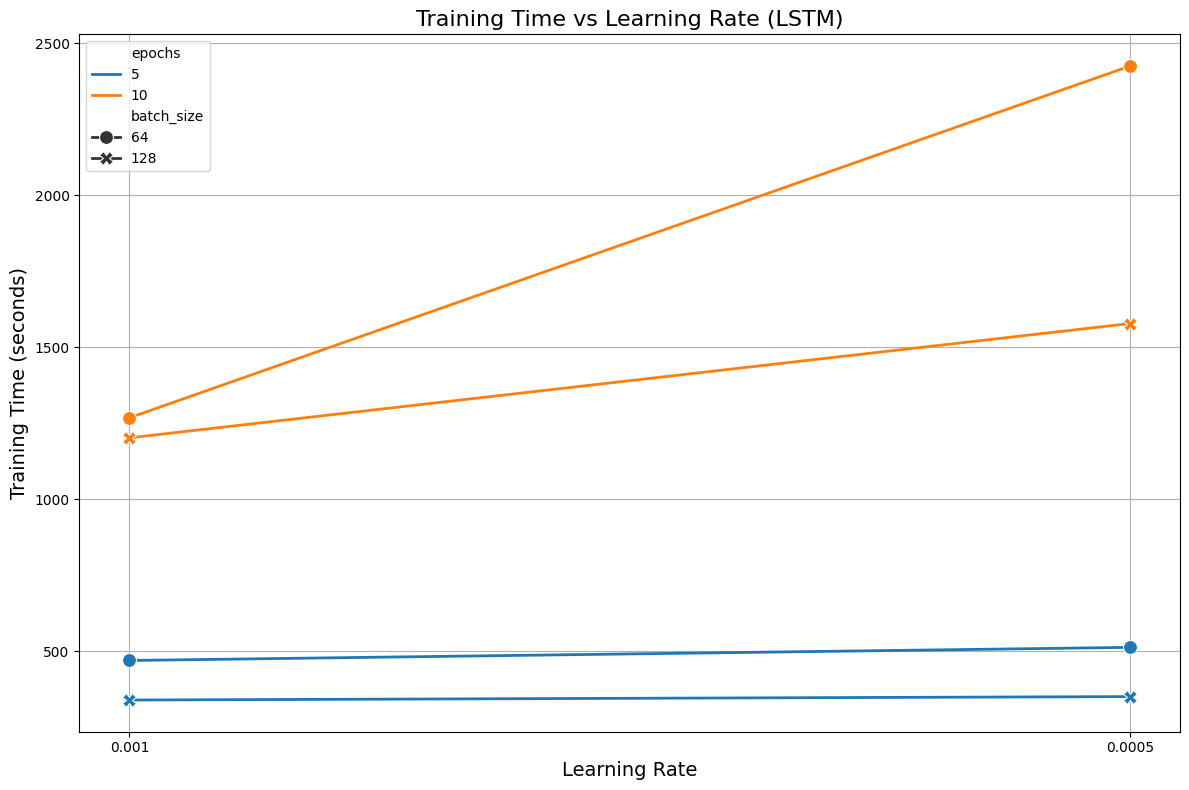

In [7]:
plt.figure(figsize=(12, 8))

# Plot Training Time vs Learning Rate, grouped by epochs, styled by batch_size
sns.lineplot(
    data=grid_df,
    x='learning_rate',
    y='Training_Time',
    hue='epochs',
    style='batch_size',
    markers=True,
    palette='tab10',
    markersize=10,
    linewidth=2,
    dashes=False,
    errorbar=None
)

# Add title and labels
plt.title("Training Time vs Learning Rate (LSTM)", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Training Time (seconds)", fontsize=14)

# Adjust grid and layout
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

BEST MODEL

In [8]:
best_model = grid_df.loc[grid_df['Accuracy'].idxmax()]
print("Best Model Parameters:")
print(best_model)

Best Model Parameters:
Accuracy                                   0.997613
Precision                                   0.99956
Recall                                     0.997574
F1-Score                                   0.998566
Normal_Detect_Rate                         0.997806
Atk_Detect_Rate                            0.997574
Training_Time                            339.016002
Confusion_Matrix      [[56840, 125], [691, 284134]]
ROC_AUC                                    0.999658
epochs                                            5
batch_size                                      128
learning_rate                                 0.001
Name: 4, dtype: object


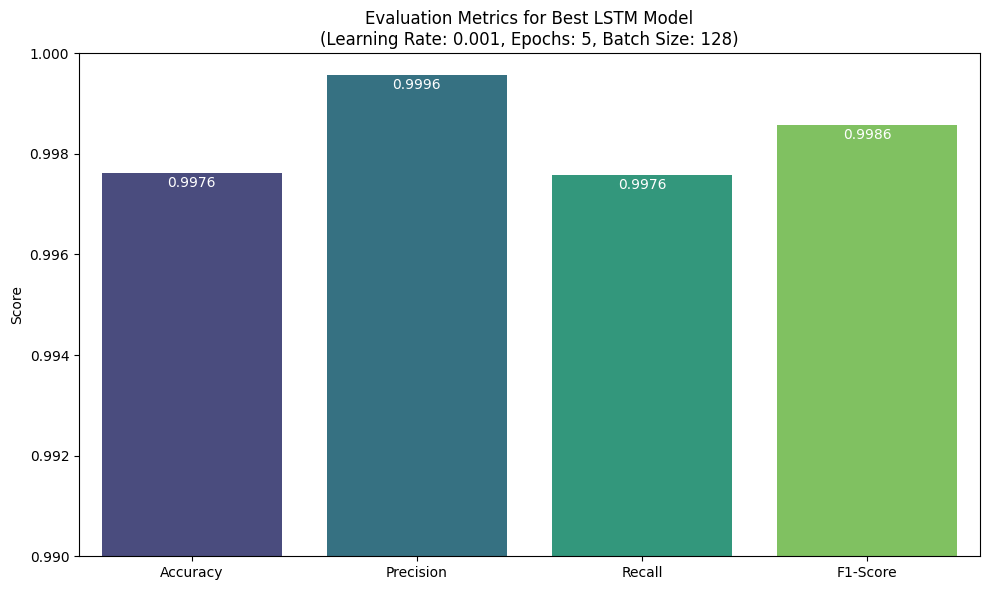

In [9]:
# Prepare evaluation metrics for plotting (CNN)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [best_model['Accuracy'], best_model['Precision'], best_model['Recall'], best_model['F1-Score']]

# Plot the evaluation metrics as a barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics, y=values, hue=metrics, palette='viridis', legend=False)

# Add labels inside the bars, closer to the top
for i, value in enumerate(values):
    plt.text(i, value - 0.00005 , f'{value:.4f}', ha='center', va='top', color='white')

# Set the y-axis to start from 0.99
plt.ylim(0.99, 1.0)

# Add plot title and labels — updated for CNN
plt.title(
    f"Evaluation Metrics for Best LSTM Model\n"
    f"(Learning Rate: {best_model['learning_rate']}, Epochs: {best_model['epochs']}, Batch Size: {best_model['batch_size']})"
)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

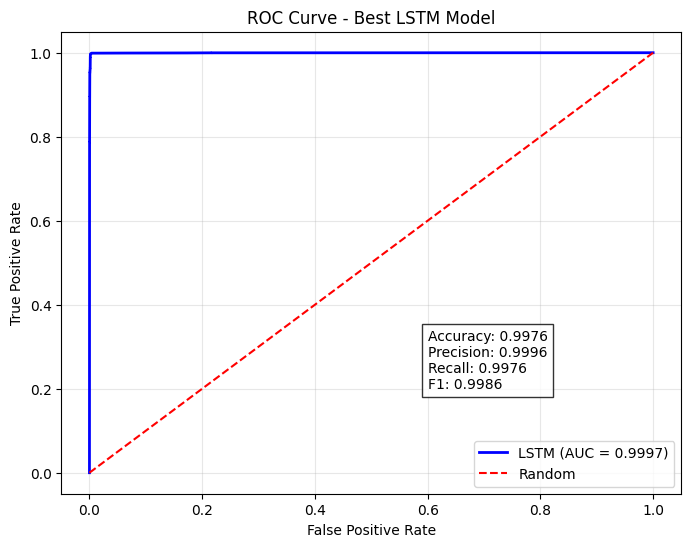

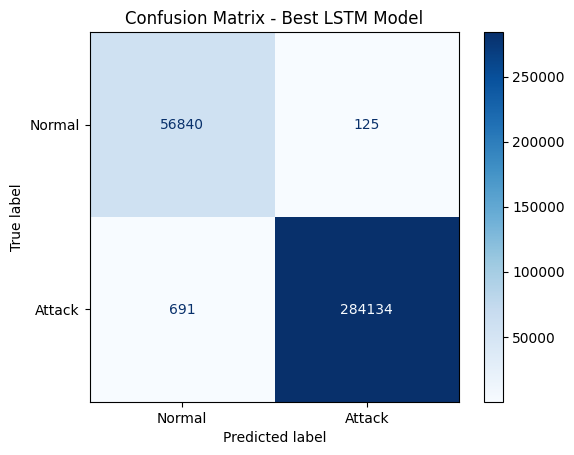

In [5]:
# ==== Plot ROC Curve ====
fpr = np.load('lstm_best_roc_fpr.npy', allow_pickle=True)
tpr = np.load('lstm_best_roc_tpr.npy', allow_pickle=True)
roc_auc = np.load('lstm_best_roc_auc.npy', allow_pickle=True)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'LSTM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best LSTM Model')
plt.legend()
plt.grid(alpha=0.3)

plt.text(0.6, 0.2, f"Accuracy: {df_best['Accuracy'].values[0]:.4f}\n"
                   f"Precision: {df_best['Precision'].values[0]:.4f}\n"
                   f"Recall: {df_best['Recall'].values[0]:.4f}\n"
                   f"F1: {df_best['F1-Score'].values[0]:.4f}",
         bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# ==== Plot Confusion Matrix ====
cm = np.array(best_result['Confusion_Matrix'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Best LSTM Model')
plt.grid(False)
plt.show()